# ResNet50 - TF Sign Language Identifier
## (by Youssef Hussein Ahmed)

### Contact with me:
[<img align="left" width="35px" style= "padding-right: 10px" src="https://cdn.jsdelivr.net/npm/simple-icons@v3/icons/linkedin.svg" />][linkedin]
[<img align="left" width="35px" style= "padding-right: 10px" src="https://cdn.jsdelivr.net/npm/simple-icons@v3/icons/upwork.svg" />][upwork]
[<img align="left" width="35px" style= "padding-right: 10px" src="https://cdn.jsdelivr.net/npm/simple-icons@v3/icons/github.svg" />][github]
[<img align="left" width="35px" style= "padding-right: 10px" src="https://cdn.jsdelivr.net/npm/simple-icons@v3/icons/facebook.svg" />][facebook]

[linkedin]: https://www.linkedin.com/in/just-youssef
[upwork]: https://www.upwork.com/freelancers/~01bf41aeaec6f293c5
[github]: https://github.com/just-youssef
[facebook]: https://www.facebook.com/just.johnny99

## Table of Content

- [1 - Packages](#1)
- [2 - Building a Residual Network](#2)
    - [2.1 - The Identity Block](#2-1)
    - [2.2 - The Convolutional Block](#2-2)
- [3 - Building ResNet50 Model](#3)
- [4 - Training ResNet50 Model](#4)

<a name='1'></a>
## 1 - Packages

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity

%matplotlib inline

<a name='2'></a>
## 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">

- The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

- Having ResNet blocks with the shortcut makes it very easy for one of the blocks to learn an identity function.

<a name='2-1'></a>
### 2.1 - The Identity Block

Implementing a powerful version of identity block, in which the skip connection "skips over" 3 hidden layers.

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">

In [20]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 

    return X

<a name='2-2'></a>
### 2.2 - The Convolutional Block

- The ResNet "convolutional block" is the second block type.
- The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">

In [21]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform (seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

<a name='3'></a>  
## 3 - Building ResNet50 Model

- The following figure describes in detail the architecture of this ResNet50 neural network.
- "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">

In [22]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(filters=64, kernel_size=(7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    
    ## Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])

    ## Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    X = identity_block(X, f=3, filters=[512, 512, 2048])

    ## AVGPOOL
    X = AveragePooling2D(pool_size=(2,2))(X) 
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [23]:
model = ResNet50()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_53 (BatchN  (None, 32, 32, 64)  256         ['conv2d_53[0][0]']        

                                                                                                  
 conv2d_63 (Conv2D)             (None, 15, 15, 256)  16640       ['activation_57[0][0]']          
                                                                                                  
 batch_normalization_63 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_63[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 15, 15, 256)  0           ['batch_normalization_63[0][0]', 
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 15, 15, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 8, 8, 512)    0           ['batch_normalization_73[0][0]', 
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 8, 8, 512)    0           ['add_21[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_67[0][0]']          
                                                                                                  
 batch_normalization_74 (BatchN  (None, 8, 8, 128)   512         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_84 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_77[0][0]']          
                                                                                                  
 batch_normalization_85 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
          

 activation_87 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_95 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_87[0][0]']          
                                                                                                  
 batch_normalization_95 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_95[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_28 (Add)                   (None, 4, 4, 1024)   0           ['batch_normalization_95[0][0]', 
                                                                  'activation_85[0][0]']          
                                                                                                  
 activatio

                                                                                                  
 add_31 (Add)                   (None, 2, 2, 2048)   0           ['batch_normalization_105[0][0]',
                                                                  'activation_94[0][0]']          
                                                                                                  
 activation_97 (Activation)     (None, 2, 2, 2048)   0           ['add_31[0][0]']                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 1, 1, 2048)  0           ['activation_97[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 2048)         0           ['average_pooling2d_1[0][0]']    
          

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<a name='4'></a>  
## 4 - Training ResNet50 Model

In [25]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_val_orig, Y_val_orig, classes = load_dataset()

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">

In [26]:
# Normalize image vectors
X_train = X_train_orig/255.
X_val = X_val_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_val = convert_to_one_hot(Y_val_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_val shape: (120, 64, 64, 3)
Y_val shape: (120, 6)


In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
34/34 [==============================] - 125s 3s/step - loss: 1.6888 - accuracy: 0.4704 - val_loss: 1.2701 - val_accuracy: 0.5167
Epoch 2/10
34/34 [==============================] - 119s 3s/step - loss: 0.5489 - accuracy: 0.7954 - val_loss: 1.2243 - val_accuracy: 0.6750
Epoch 3/10
34/34 [==============================] - 117s 3s/step - loss: 0.3583 - accuracy: 0.8907 - val_loss: 0.7889 - val_accuracy: 0.7833
Epoch 4/10
34/34 [==============================] - 117s 3s/step - loss: 0.3133 - accuracy: 0.9046 - val_loss: 1.0035 - val_accuracy: 0.7167
Epoch 5/10
34/34 [==============================] - 117s 3s/step - loss: 0.2280 - accuracy: 0.9222 - val_loss: 0.6097 - val_accuracy: 0.8250
Epoch 6/10
34/34 [==============================] - 118s 3s/step - loss: 0.1912 - accuracy: 0.9426 - val_loss: 0.4264 - val_accuracy: 0.8750
Epoch 7/10
34/34 [==============================] - 122s 4s/step - loss: 0.1625 - accuracy: 0.9463 - val_loss: 0.5366 - val_accuracy: 0.8917
Epoch 8/10
34

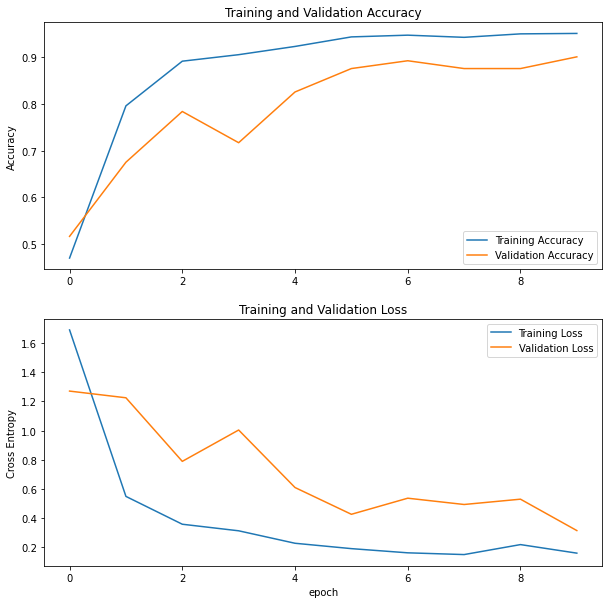

In [27]:
# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()